In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
%tensorflow_version 1.x

In [4]:

import datetime
import os
import cv2
import keras
import keras.callbacks
import keras.utils
import numpy as np

import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
from IPython.display import Image, display

from keras.layers import Input,Reshape,Permute

#from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model,load_model

import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D


Using TensorFlow backend.


1.15.0


In [0]:
def SegNet(input_shape=(360, 480, 3), classes=12):
    img_input = Input(shape=input_shape)
    x = img_input
    # Encoder
    x = Convolution2D(64, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Convolution2D(128, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Convolution2D(256, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Convolution2D(512, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Decoder
    x = Convolution2D(512, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(256, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(128, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(64, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(classes, 1, 1, border_mode="valid")(x)
    x = Reshape((input_shape[0]*input_shape[1], classes))(x)
    x = Activation("softmax")(x)
    model = Model(img_input, x)
    return model


In [6]:
dataset = np.load('/content/drive/My Drive/CamVid/temp/dataset-all5.npz')
train_x = dataset['train_x']
train_y = dataset['train_y']
test_x = dataset['test_x']
test_y = dataset['test_y']
print(train_x.shape)
print(train_y.shape)

(367, 360, 480, 3)
(367, 172800, 12)


In [14]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(session)

model = SegNet()
model.compile(loss='binary_crossentropy',optimizer='adadelta',metrics=['accuracy'])

callbacks = []
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
filename = 'dataset-all-model-{epoch:04d}.h5'
directory = f'/content/drive/My Drive/camvid-cnn/epochs-All/{timestamp}/'
print(f'{directory}')
os.makedirs(directory, exist_ok=True)
callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=f'{directory}{filename}',
        monitor='val_loss',
        verbose=0,
        save_best_only=False,
        save_weights_only=False,
        mode='auto',
        period=50
        ))
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]
model.save_weights(f'{directory}{filename}'.format(epoch=0))
model.fit(
            x=train_x,
            y=train_y,
            validation_data=(test_x, test_y),
            epochs=300,
            batch_size=10,
            class_weight=class_weighting,
            shuffle=True,
            verbose=1,
            callbacks=callbacks)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `

/content/drive/My Drive/camvid-cnn/epochs-All/20191229142704/


Train on 367 samples, validate on 233 samples
Epoch 1/300
367/367 [==============================] - 28s 76ms/step - loss: 0.1448 - acc: 0.9503 - val_loss: 0.1633 - val_acc: 0.9432
Epoch 2/300
367/367 [==============================] - 22s 59ms/step - loss: 0.1070 - acc: 0.9617 - val_loss: 0.1445 - val_acc: 0.9472
Epoch 3/300
367/367 [==============================] - 22s 59ms/step - loss: 0.0937 - acc: 0.9664 - val_loss: 0.1964 - val_acc: 0.9312
Epoch 4/300
367/367 [==============================] - 22s 59ms/step - loss: 0.0880 - acc: 0.9686 - val_loss: 0.1361 - val_acc: 0.9483
Epoch 5/300
367/367 [==============================] - 22s 59ms/step - loss: 0.0854 - acc: 0.9693 - val_loss: 0.1345 - val_acc: 0.9526
Epoch 6/300
367/367 [==============================] - 22s 59ms/step - loss: 0.0822 - acc: 0.9701 - val_loss: 0.1366 - val_acc: 0.9498
Epoch 7/300
367/367 [==============================] - 22s 59ms/step - loss: 0.0

In [24]:
dataset = np.load('/content/drive/My Drive/CamVid/temp/dataset-all5.npz')
val_x = dataset['val_x']
val_y = dataset['val_y']



model = SegNet()
model.load_weights('/content/drive/My Drive/camvid-cnn/epochs-All/20191229142704/dataset-all-model-0300.h5')
model.compile(loss='binary_crossentropy',optimizer='adadelta',metrics=['accuracy'])
score = model.evaluate(val_x, val_y) 
print("accuracy : " , score[1])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `

101/101 [==============================] - 3s 27ms/step
accuracy :  0.9747915132210987


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


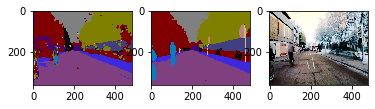

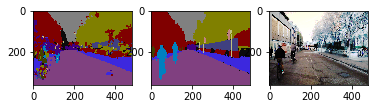

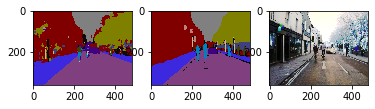

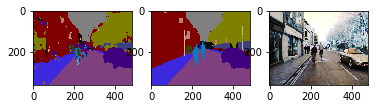

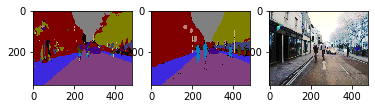

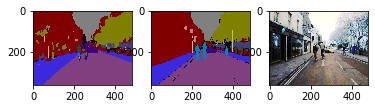

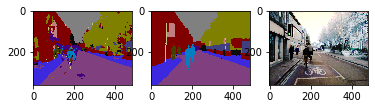

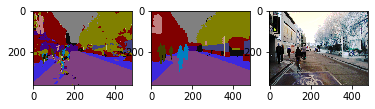

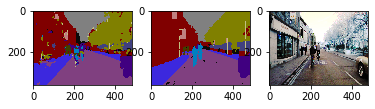

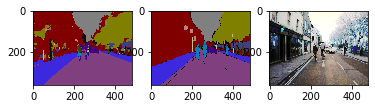

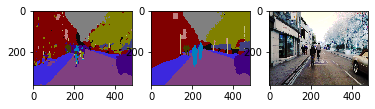

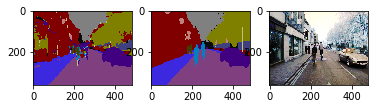

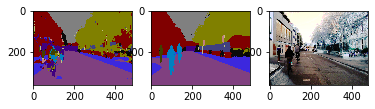

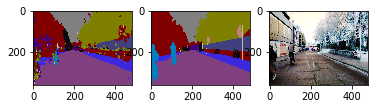

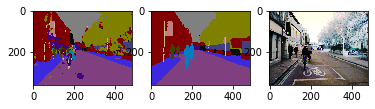

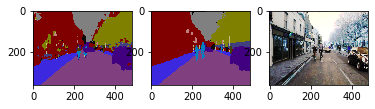

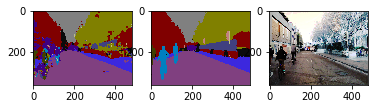

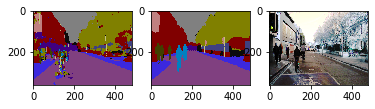

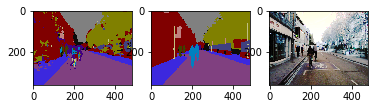

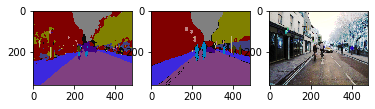

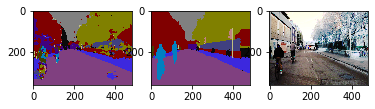

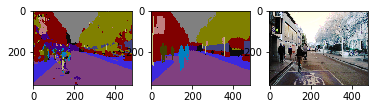

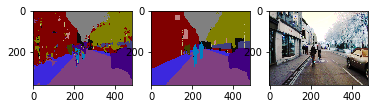

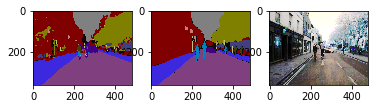

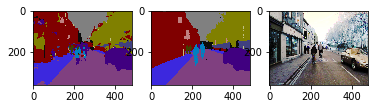

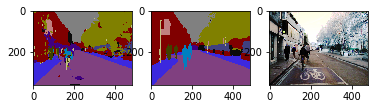

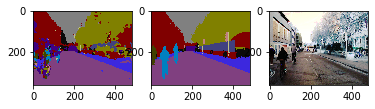

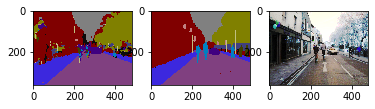

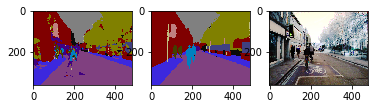

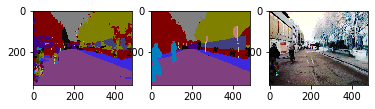

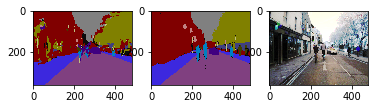

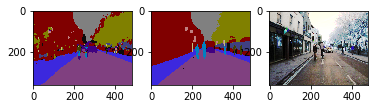

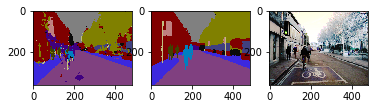

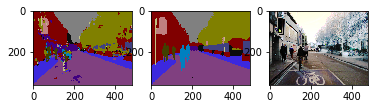

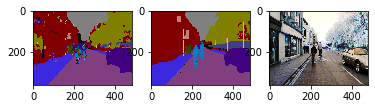

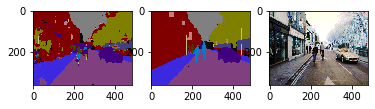

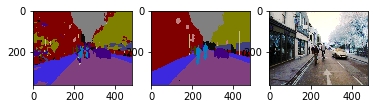

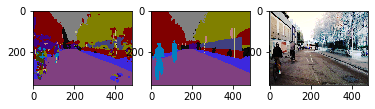

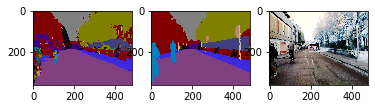

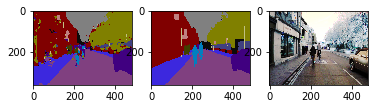

In [15]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]

    return rgb


for i in range(40):
  output = model.predict(val_x[i:i+1])
  y_org = val_y[i:i+1]
  x_org = val_x[i:i+1]
  pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)))
  pred2 = visualize(np.argmax(y_org[0],axis=1).reshape((360,480)))
  pred3 = x_org[0]
  f, axarr = plt.subplots(1,3)
  axarr[0].imshow(pred)
  axarr[1].imshow(pred2)
  axarr[2].imshow(pred3)
